# Time series clustering exercise

# Data

Download the census bureau business data for all years 1993-2014. You can investigate using the API (I have not done it with the census bureau). I did is as you see below

The data is on the github repo. Each file is the economic census for 1 year. 
Download it programmatically and move it to PUIdata

 Download the NYC zipcodes shapefile. One of many ways in which you can get the zipcodes shapefile for NYC
 https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip


## You can use zipfile module in python to unzip the files
it should be installed in your system, but if it is not you can get the code with wget from here
https://github.com/python/cpython/blob/2.7/Lib/zipfile.py
remembering to use the raw link
(or you can use the usual shell commands)

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
#import urllib
import urllib.request as urllib
import requests
import os
import io
import json
import pylab as pl
import shapely
from fiona.crs import from_epsg
import zipfile 
%pylab inline




Populating the interactive namespace from numpy and matplotlib


In [2]:
os.environ["PUIDATA"] = "%s/PUIDATA"%os.getenv("HOME")
os.getenv("PUIDATA")

'/nfshome/mb6203/PUIDATA'

In [3]:
url = "https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip"
urllib.urlretrieve(url, "zipcodes_file.gz")
!unzip -o zipcodes_file.gz -d $PUIDATA

Archive:  zipcodes_file.gz
  inflating: /nfshome/mb6203/PUIDATA/ZIP_CODE_040114.shx  
  inflating: /nfshome/mb6203/PUIDATA/ZIP_CODE_040114.dbf  
  inflating: /nfshome/mb6203/PUIDATA/ZIP_CODE_040114.prj  
  inflating: /nfshome/mb6203/PUIDATA/ZIP_CODE_040114.sbn  
  inflating: /nfshome/mb6203/PUIDATA/ZIP_CODE_040114.sbx  
  inflating: /nfshome/mb6203/PUIDATA/ZIP_CODE_040114.shp  
  inflating: /nfshome/mb6203/PUIDATA/ZIP_CODE_040114.shp.xml  


In [4]:
nyc_zipcodes = gpd.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/" + 
                                     "ZIP_CODE_040114.shp")

(905410.75604293647,
 1075212.5382562785,
 112386.35181947277,
 280345.45402395504)

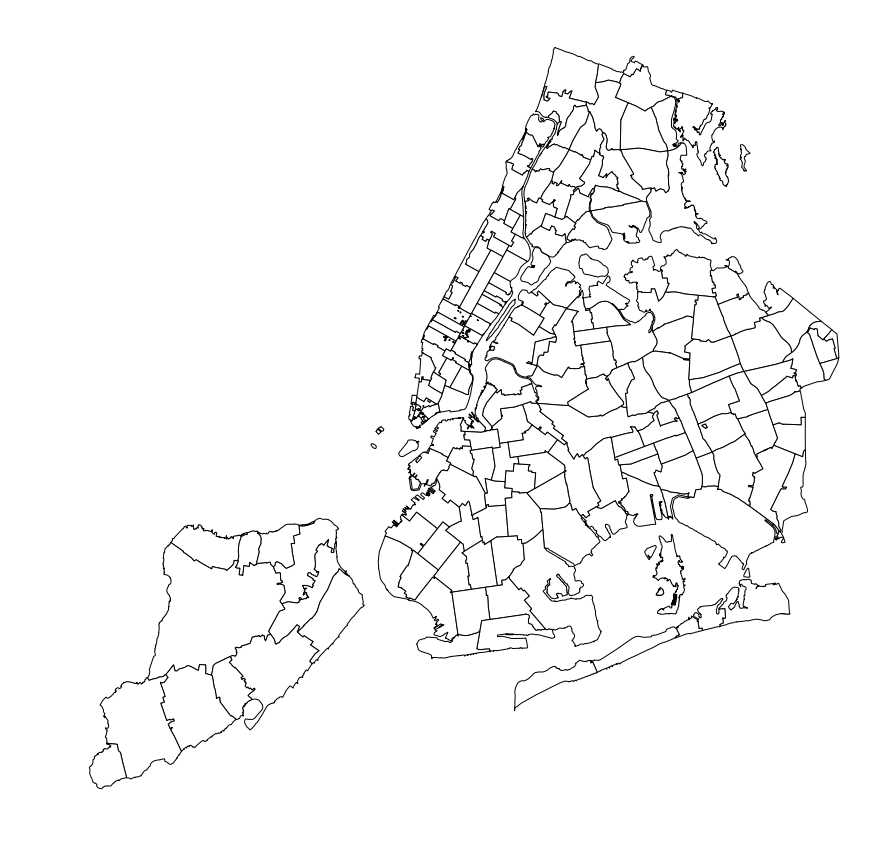

In [5]:
#fig = plt.figure(figsize=(10,4))
nyc_zipcodes.plot(figsize=(20,15), color='white', edgecolor='black')
plt.axis('off')

# Data cleaning

you may need to clean your data: for some NYC zip codes there may be no info
sanity check: you should have 20 (N_timestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)


IMPORTANT: read the instructions below on pre-processing. Afte rthat:

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))



## TASKS:
    
    1. get and prep your data.
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means
    in **a few** clusters (as discussed there is no real good, sound way to 
    decide what a good number is here. try a few options, keeping in mind 
    a few is more than a couple, but i recommand you stay within the 
    single digit numbers)
    
    3. plot the cluster centers (if you used K means those are the means of 
    the clusters). you can plot for example the cluster centers overlayed on 
    each time series (using the alpha channel to control the opacity in the 
    plot may be helpful here).
    
    4. Use another clustering algorithm (of your choice)
    
    5. overlay your data on a NYC map: you can use shapefiles for the 
    zip codes and different colors for different clusters
    
    6. Compare the results of the 2 algorithms
    
    7. attempt an interpretation. this is dangerous ground: clustering is 
    an exploratory tool so you do not want to jump to conclusions because 
    you see some clusters! but seeing structure in your data can inform 
    your next moves as an investigator. 
    

Note on preprocessing: the preparation of these data should include the "standardization" of the time seris. 
*Always when you apply a moachine learning model you should standardize the data or whiten it.*
These operations may be complicated preprocessing operation, they can for example invoke PCA, and they are aimed at removing covariance in the feature space.

The simplest version of whitening *standardizes each feature*" from every column (feature) you subtract the mean and you divide it by the standard deviation.

But the time series preprocessing is different if you want to use each time stamp as feature: because you want to maintain the coherence of the data, i.e. you **do not want** to treat each feature as an independent feature! the pattenrs in the time series are what you are clustering on (time series goes up and down, creating a pattern) and those patterns would be lost by whitening.

*So when you cluster or otherwise use a time series in a model, using each timestamp as a feature, you want to standardize the observations, not the features.* 

**From each row of your table (observation, in this case each zipcode) subtract the mean and you divide the row by the standard deviation.**

In [6]:
puidata = os.getenv("PUIDATA")

In [7]:
# Download data from GitHub

zip_list = ['/zbp00totals.zip',
        '/zbp01totals.zip',
        '/zbp02totals.zip',
        '/zbp03totals.zip',
        '/zbp04totals.zip',
        '/zbp05totals.zip',
        '/zbp06totals.zip',
        '/zbp07totals.zip',
        '/zbp08totals.zip',
        '/zbp09totals.zip',
        '/zbp10totals.zip',
        '/zbp11totals.zip',
        '/zbp12totals.zip',
        '/zbp13totals.zip',
        '/zbp94totals.zip',
        '/zbp95totals.zip',
        '/zbp96totals.zip',
        '/zbp97totals.zip',
        '/zbp98totals.zip',
        '/zbp99totals.zip']

for i in zip_list:
    
    urllib.urlretrieve('https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55' + i,
                   puidata + i)
    zip_ref = zipfile.ZipFile(puidata + i, 'r')
    zip_ref.extractall(puidata)
    zip_ref.close()

In [8]:
df = pd.read_csv(puidata + '/zbp94totals.txt')

#df.shape
#df.columns

# keep only zipcodes and # of establishments
df = df[['zip', 'est']]
#df.shape

zip_txt = ['/zbp95totals.txt',
           '/zbp96totals.txt',
           '/zbp97totals.txt',
           '/zbp98totals.txt',
           '/zbp99totals.txt',
           '/zbp00totals.txt',
           '/zbp01totals.txt',
           '/zbp02totals.txt',
           '/zbp03totals.txt',
           '/zbp04totals.txt',
           '/zbp05totals.txt',
           '/zbp06totals.txt',
           '/zbp07totals.txt',
           '/zbp08totals.txt',
           '/zbp09totals.txt',
           '/zbp10totals.txt',
           '/zbp11totals.txt',
           '/zbp12totals.txt',
           '/zbp13totals.txt']



for i in zip_txt:
    df_95_13 = pd.read_csv(puidata + i)
    df_95_13.columns = df_95_13.columns.str.lower() # convert to strings
    df_95_13 = df_95_13[['zip', 'est']]
    df = df.join(df_95_13.set_index('zip'), on='zip', how='outer', rsuffix=i) # change this?



In [9]:
df.head()

,zip,est,est/zbp95totals.txt,est/zbp96totals.txt,est/zbp97totals.txt,est/zbp98totals.txt,est/zbp99totals.txt,est/zbp00totals.txt,est/zbp01totals.txt,est/zbp02totals.txt,...,est/zbp04totals.txt,est/zbp05totals.txt,est/zbp06totals.txt,est/zbp07totals.txt,est/zbp08totals.txt,est/zbp09totals.txt,est/zbp10totals.txt,est/zbp11totals.txt,est/zbp12totals.txt,est/zbp13totals.txt
0,1001.0,439.0,439.0,433.0,457.0,444.0,469.0,493.0,490.0,490.0,...,500.0,509.0,509.0,503.0,477.0,458.0,448.0,436.0,453.0,439.0
1,1002.0,450.0,467.0,487.0,500.0,490.0,558.0,563.0,587.0,566.0,...,584.0,589.0,582.0,596.0,584.0,571.0,570.0,558.0,572.0,572.0
2,1003.0,10.0,10.0,13.0,15.0,14.0,13.0,13.0,13.0,15.0,...,15.0,12.0,12.0,16.0,17.0,16.0,16.0,16.0,15.0,15.0
3,1004.0,47.0,48.0,47.0,41.0,31.0,35.0,48.0,37.0,23.0,...,43.0,31.0,30.0,20.0,18.0,18.0,21.0,19.0,16.0,16.0
4,1005.0,92.0,95.0,101.0,104.0,95.0,82.0,86.0,90.0,94.0,...,97.0,94.0,98.0,106.0,97.0,87.0,96.0,91.0,94.0,97.0


In [10]:
df = df.rename(columns={'est':'1994',
                  'est/zbp95totals.txt':'1995',
                  'est/zbp96totals.txt':'1996',
                  'est/zbp97totals.txt':'1997',
                  'est/zbp98totals.txt':'1998',
                  'est/zbp99totals.txt':'1999',
                  'est/zbp00totals.txt':'2000',
                  'est/zbp01totals.txt':'2001',
                  'est/zbp02totals.txt':'2002',
                  'est/zbp03totals.txt':'2003',
                  'est/zbp04totals.txt':'2004',
                  'est/zbp05totals.txt':'2005',
                  'est/zbp06totals.txt':'2006',
                  'est/zbp07totals.txt':'2007',
                  'est/zbp08totals.txt':'2008',
                  'est/zbp09totals.txt':'2009',
                  'est/zbp10totals.txt':'2010',
                  'est/zbp11totals.txt':'2011',
                  'est/zbp12totals.txt':'2012',
                  'est/zbp13totals.txt':'2013'})
df.head()

,zip,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
0,1001.0,439.0,439.0,433.0,457.0,444.0,469.0,493.0,490.0,490.0,...,500.0,509.0,509.0,503.0,477.0,458.0,448.0,436.0,453.0,439.0
1,1002.0,450.0,467.0,487.0,500.0,490.0,558.0,563.0,587.0,566.0,...,584.0,589.0,582.0,596.0,584.0,571.0,570.0,558.0,572.0,572.0
2,1003.0,10.0,10.0,13.0,15.0,14.0,13.0,13.0,13.0,15.0,...,15.0,12.0,12.0,16.0,17.0,16.0,16.0,16.0,15.0,15.0
3,1004.0,47.0,48.0,47.0,41.0,31.0,35.0,48.0,37.0,23.0,...,43.0,31.0,30.0,20.0,18.0,18.0,21.0,19.0,16.0,16.0
4,1005.0,92.0,95.0,101.0,104.0,95.0,82.0,86.0,90.0,94.0,...,97.0,94.0,98.0,106.0,97.0,87.0,96.0,91.0,94.0,97.0


In [11]:
df.shape

(42653, 21)

In [12]:
zipshp = nyc_zipcodes

In [13]:
# Look at the shapefile
zipshp.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 13 columns):
ZIPCODE       263 non-null object
BLDGZIP       263 non-null object
PO_NAME       263 non-null object
POPULATION    263 non-null float64
AREA          263 non-null float64
STATE         263 non-null object
COUNTY        263 non-null object
ST_FIPS       263 non-null object
CTY_FIPS      263 non-null object
URL           263 non-null object
SHAPE_AREA    263 non-null float64
SHAPE_LEN     263 non-null float64
geometry      263 non-null object
dtypes: float64(4), object(9)
memory usage: 26.8+ KB


In [14]:
import geopandas as gp
nyczipsshp = gp.read_file(os.getenv("PUIDATA") + "/ZIP_CODE_040114.shp")
#nyczipsshp.plot()
#nyczipsshp.drop_duplicates("ZIPCODE").plot()
#nyczipsshp
print("ZIPCODES:",
      len(np.unique(nyczipsshp.ZIPCODE)), "POLYGONS:",
      len(nyczipsshp.ZIPCODE),
      "the difference is due to island with same zip as parts of land,",
      "but disjoint shapes")
nyczips = nyczipsshp.ZIPCODE.values.astype(int)
print("number of NYC zip codes:", len(nyczips))

ZIPCODES: 248 POLYGONS: 263 the difference is due to island with same zip as parts of land, but disjoint shapes
number of NYC zip codes: 263


In [15]:
# Convert the zipcode to a numeric to drop duplicative zips later
zipshp['ZIPCODE'] = pd.to_numeric(zipshp['ZIPCODE'])

# Drop the duplicative zips
#zipshp = zipshp.drop_duplicates('ZIPCODE')

In [16]:
zipshp.info() # Should get about ~250 per Dr. Bianco's note

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 13 columns):
ZIPCODE       263 non-null int64
BLDGZIP       263 non-null object
PO_NAME       263 non-null object
POPULATION    263 non-null float64
AREA          263 non-null float64
STATE         263 non-null object
COUNTY        263 non-null object
ST_FIPS       263 non-null object
CTY_FIPS      263 non-null object
URL           263 non-null object
SHAPE_AREA    263 non-null float64
SHAPE_LEN     263 non-null float64
geometry      263 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 26.8+ KB


In [17]:
# Merge the geopandas dataframe and the establishments dataframe

nyc_establishments = pd.merge(zipshp[['ZIPCODE']], df, left_on='ZIPCODE', right_on='zip', how='left')
nyc_establishments = nyc_establishments.drop(['zip'], axis = 1)
nyc_establishments = nyc_establishments.dropna()
nyc_establishments

,ZIPCODE,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
0,11436,51.0,50.0,53.0,51.0,51.0,58.0,65.0,57.0,78.0,...,84.0,82.0,80.0,84.0,90.0,92.0,98.0,101.0,95.0,99.0
1,11213,406.0,420.0,433.0,456.0,476.0,473.0,477.0,493.0,546.0,...,570.0,556.0,565.0,556.0,592.0,621.0,675.0,674.0,726.0,755.0
2,11212,505.0,494.0,502.0,527.0,519.0,541.0,520.0,527.0,577.0,...,586.0,587.0,570.0,587.0,602.0,647.0,699.0,713.0,721.0,731.0
3,11225,381.0,387.0,388.0,410.0,416.0,409.0,417.0,422.0,479.0,...,492.0,491.0,499.0,514.0,520.0,543.0,580.0,597.0,623.0,673.0
4,11218,985.0,1015.0,1049.0,1075.0,1118.0,1149.0,1161.0,1180.0,1228.0,...,1295.0,1332.0,1331.0,1377.0,1397.0,1457.0,1474.0,1523.0,1605.0,1687.0
5,11226,879.0,882.0,885.0,904.0,942.0,923.0,917.0,884.0,967.0,...,1044.0,1049.0,1015.0,1049.0,1083.0,1097.0,1127.0,1169.0,1229.0,1256.0
6,11219,1650.0,1708.0,1768.0,1863.0,1928.0,1997.0,2079.0,2153.0,2172.0,...,2286.0,2343.0,2351.0,2391.0,2396.0,2487.0,2581.0,2647.0,2696.0,2777.0
7,11210,763.0,783.0,779.0,806.0,815.0,776.0,792.0,816.0,839.0,...,842.0,875.0,893.0,887.0,906.0,919.0,990.0,1030.0,1006.0,1003.0
8,11230,1411.0,1465.0,1537.0,1563.0,1605.0,1670.0,1753.0,1807.0,1829.0,...,1925.0,1930.0,1934.0,1934.0,1945.0,1984.0,2026.0,2062.0,1999.0,2095.0
9,11204,1287.0,1297.0,1334.0,1374.0,1444.0,1481.0,1656.0,1686.0,1569.0,...,1733.0,1778.0,1806.0,1858.0,1826.0,1817.0,1902.0,1960.0,2024.0,2108.0


In [18]:
zips = nyc_establishments[['ZIPCODE']]
zips.head()

,ZIPCODE
0,11436
1,11213
2,11212
3,11225
4,11218


In [19]:
mask = nyc_establishments.drop(['ZIPCODE'], axis=1)
mask.head()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
0,51.0,50.0,53.0,51.0,51.0,58.0,65.0,57.0,78.0,74.0,84.0,82.0,80.0,84.0,90.0,92.0,98.0,101.0,95.0,99.0
1,406.0,420.0,433.0,456.0,476.0,473.0,477.0,493.0,546.0,569.0,570.0,556.0,565.0,556.0,592.0,621.0,675.0,674.0,726.0,755.0
2,505.0,494.0,502.0,527.0,519.0,541.0,520.0,527.0,577.0,581.0,586.0,587.0,570.0,587.0,602.0,647.0,699.0,713.0,721.0,731.0
3,381.0,387.0,388.0,410.0,416.0,409.0,417.0,422.0,479.0,488.0,492.0,491.0,499.0,514.0,520.0,543.0,580.0,597.0,623.0,673.0
4,985.0,1015.0,1049.0,1075.0,1118.0,1149.0,1161.0,1180.0,1228.0,1247.0,1295.0,1332.0,1331.0,1377.0,1397.0,1457.0,1474.0,1523.0,1605.0,1687.0


In [20]:
# Standardizing
vals = ((mask.T - mask.mean(1)) / mask.std(1)).T
vals.head()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
0,-1.279776,-1.333890,-1.171550,-1.279776,-1.279776,-0.900984,-0.522192,-0.955097,0.181279,-0.035174,0.505958,0.397732,0.289505,0.505958,0.830637,0.938863,1.263543,1.425882,1.101203,1.317656
1,-1.452072,-1.312784,-1.183446,-0.954616,-0.755634,-0.785482,-0.745685,-0.586500,-0.059197,0.169632,0.179581,0.040294,0.129836,0.040294,0.398462,0.686986,1.224237,1.214288,1.731641,2.020165
2,-1.063574,-1.206598,-1.102581,-0.777527,-0.881544,-0.595498,-0.868542,-0.777527,-0.127421,-0.075412,-0.010402,0.002600,-0.218436,0.002600,0.197632,0.782728,1.458839,1.640869,1.744886,1.874907
3,-1.245223,-1.174371,-1.162563,-0.902772,-0.831920,-0.914581,-0.820112,-0.761068,-0.087975,0.018303,0.065538,0.053729,0.148199,0.325329,0.396181,0.667780,1.104700,1.305447,1.612473,2.202906
4,-1.504638,-1.353797,-1.182844,-1.052115,-0.835910,-0.680041,-0.619705,-0.524172,-0.282827,-0.187294,0.054051,0.240088,0.235060,0.466350,0.566910,0.868592,0.954069,1.200442,1.612741,2.025039


In [21]:
clean = zips.join(vals)

In [22]:
clean.head()

,ZIPCODE,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
0,11436,-1.279776,-1.333890,-1.171550,-1.279776,-1.279776,-0.900984,-0.522192,-0.955097,0.181279,...,0.505958,0.397732,0.289505,0.505958,0.830637,0.938863,1.263543,1.425882,1.101203,1.317656
1,11213,-1.452072,-1.312784,-1.183446,-0.954616,-0.755634,-0.785482,-0.745685,-0.586500,-0.059197,...,0.179581,0.040294,0.129836,0.040294,0.398462,0.686986,1.224237,1.214288,1.731641,2.020165
2,11212,-1.063574,-1.206598,-1.102581,-0.777527,-0.881544,-0.595498,-0.868542,-0.777527,-0.127421,...,-0.010402,0.002600,-0.218436,0.002600,0.197632,0.782728,1.458839,1.640869,1.744886,1.874907
3,11225,-1.245223,-1.174371,-1.162563,-0.902772,-0.831920,-0.914581,-0.820112,-0.761068,-0.087975,...,0.065538,0.053729,0.148199,0.325329,0.396181,0.667780,1.104700,1.305447,1.612473,2.202906
4,11218,-1.504638,-1.353797,-1.182844,-1.052115,-0.835910,-0.680041,-0.619705,-0.524172,-0.282827,...,0.054051,0.240088,0.235060,0.466350,0.566910,0.868592,0.954069,1.200442,1.612741,2.025039


In [23]:
clean.shape

(243, 21)

In [24]:
# 20 years of data and 263 zipcodes
cbs.shape

NameError: name 'cbs' is not defined

In [ ]:
#cleaning all missing values
cleancsb.shape

In [ ]:
#then the standardization will look like:
vals = ((cleancsb.T - cleancsb.mean(1)) / cleancsb.std(1)).T


vals.mean(axis=1) should return 0 (or something very small) everywhere

vals.mean(axis=1).shape should be (260,)

vals.std(axis=1) should return 1 everywhere

vals.std(axis=1).shape

In [ ]:
#cluster with kmeans
km = KMeans(n_clusters=nc, random_state=444).fit(vals)


In [ ]:
#each observation in the km object has a label: 
#that is the cluster assigned to that observation
km.labels_.shape

### The map of the clusters may look something like this

In [ ]:
...

### Figure 3: 
cloropleth of  cluster centers for 5 k-means clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes: each color indicates a cluster. The business pattern time series are plotted at the top.

### or maybe like this, depending on which algorithm you use, and how you proceed to preprocess your data and how you cluster it. There is no one correct answer, but general trends should be retrieved.

In [ ]:
...

### Figure 9: 
As figures 3, 5, 7 for hierarchical agglomerative clustering in 7 clusters, with smoothed time series

# If you want to use agglomerative clustering

In [ ]:
agc = AgglomerativeClustering(n_clusters=nc, linkage='average').fit()
labelsag = agc.labels_
centroidsag = np.zeros((nc, vals.shape[1]))



### And if you use hierarchical clustering in scipy you can make a dandrogram it may look like this:

In [ ]:
import scipy.cluster as scp
fig = pl.figure(figsize=(20,10), dpi=150)
pl.ylabel("distance")
ddg = scp.hierarchy.dendrogram(scp.hierarchy.linkage(vals, method='ward'),
                               labels = zipcodes,
                               leaf_rotation=90.,  # rotates the x axis labels
                               leaf_font_size=8.)  # font size for the x axis labels)


In [ ]:
!pwd